In [1]:
import requests
from pprint import pprint
import time
from fake_useragent import UserAgent
ua = UserAgent(verify_ssl=False)
session = requests.session()

import pandas as pd
import collections as c
import sqlite3
from html import unescape
from bs4 import BeautifulSoup
import re

import numpy as np
import matplotlib.pyplot as plt

from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
import seaborn as sns
from nltk.corpus import stopwords

Находится следующая информация:
- заголовок
- подзаголовок
- текст
- категория
- ключевые слова
- дата и время

первый обход: ищем ссылки

достаёт ссылку на нужную страницу

In [2]:
def my_link(my_text):
    mysoup = BeautifulSoup(str(my_text), 'html.parser')
    l = mysoup.find('a')
    link = l.attrs['href']
    return link

поиск по ссылке (подзаголовок, подпись к фото, тэги, весь текст):

In [3]:
def info(link):
    my_tags = []
    foto_text = None
    subh = None
    clean_text = ''
    req = session.get(link, headers={'User-Agent': ua.random})
    page = req.text
    soup = BeautifulSoup(page, 'html.parser')
    subheader = soup.find('h2') #подзаголовок
    foto = soup.find('p', {'class': 'wp-caption-text'}) #подпись к фото
    article = soup.find('div', {'class': 'entry-content'})
    article_soup = BeautifulSoup(str(article), 'html.parser')
    my_text = article_soup.find_all('p', {'class': None})
    for t in my_text:
        clean_text += (' ' + t.text)
    try:
        foto_text = foto.text
        subh = subheader.text
    except Exception as e:
            print(e)
    tags = soup.find_all('a', {'rel': ['tag']})
    for tag in tags:
        if 'category' not in tag.attrs['rel']:
            my_tags.append(tag.text)
    return subh, foto_text, my_tags, clean_text

с основной страницы достаёт заголовок, категорию и ссылку:

In [4]:
def find_page(number, seen):
    data = {}
    i = 1
    url = f'http://rk.karelia.ru/types/post-news/page/{number}/'
    req = session.get(url, headers={'User-Agent': ua.random})
    page = req.text
    soup = BeautifulSoup(page, 'html.parser')
    news = soup.find_all('header', {'class': 'entry-header'})
    my_news = [n for n in news]
    for n in my_news:
        n_soup = BeautifulSoup(str(n), 'html.parser')
        header = n_soup.find('h2', {'class': 'entry-title'}) #заголовок
        my_head = header.text[22:]
        if not my_head in seen:
            cat = n_soup.find('div', {'class': 'entry-cat'}) #катеория
            time = n_soup.find('time') #время
            #link = my_link(header)
            my_cat = cat.text
            my_date = time.text.split(' - ')[0]
            my_time = time.text.split(' - ')[1]
            my_year = my_date.split('-')[2]
            my_month = my_date.split('-')[1]
            my_day = my_date.split('-')[0]
            #print('cat', my_cat, 'time', my_time, 'head', my_head)
            new_soup = BeautifulSoup(str(header), 'html.parser')
            l = new_soup.find('a')
            l_2 = my_link(header)
            s, f, t, ct = info(l_2)
            my_id = 100*number+i
            i += 1
            #print('subh', s, 'foto', f, 'tags', t, my_id, ct)
            data[my_id] = [my_head, s, ct, my_cat, t, my_time, my_year, my_month, my_day, f]
            seen.append(my_head)
    #print(data)
    return data, seen

Структура базы данных:

<img src = 'https://raw.githubusercontent.com/YanaKoko/try/master/database_py2.png'>

In [4]:
conn = sqlite3.connect('my_news_two.db')
cur = conn.cursor()

In [4]:
cur.execute("""
CREATE TABLE IF NOT EXISTS my_texts 
(my_id int PRIMARY KEY, time text, year int,
month int, day int, article text, category text)
""")

conn.commit()

cur.execute("""
CREATE TABLE IF NOT EXISTS info 
(my_id int PRIMARY KEY, head text, subhead text, foto text)
""")

conn.commit()

cur.execute("""
CREATE TABLE IF NOT EXISTS my_tags 
(text_id int, id_tag int)
""")

conn.commit()

cur.execute("""
CREATE TABLE IF NOT EXISTS my_tags_info 
(id_tag int PRIMARY KEY, tag text)
""")

conn.commit()

In [7]:
def make_data():
    i = 0
    seen = []
    tags = []
    for x in range(1,30):
        data = find_page(x, seen)[0]
        seen = find_page(x, seen)[1]
        #print(data)
        for k in data.keys():
            cur.execute('INSERT INTO my_texts VALUES (?, ?, ?, ?, ?, ?, ?)', (k, data[k][5], data[k][6],
                     data[k][7], data[k][8], data[k][2], data[k][3]))
            conn.commit()
            cur.execute('INSERT INTO info VALUES (?, ?, ?, ?)', (k, data[k][0], data[k][1], data[k][9]))
            conn.commit()
            
            for tag in data[k][4]:
                if not tag in tags:
                    tags.append(tag)
                    cur.execute('INSERT INTO my_tags_info VALUES (?, ?)', (tags.index(tag), tag))
                    conn.commit()
                tag_id = tags.index(tag) #присваивает уникальный № для тэга
                cur.execute('INSERT INTO my_tags VALUES (?, ?)', (k, tag_id))
                conn.commit()
                i += 1

In [8]:
make_data()

'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute

In [5]:
one_query = """
SELECT my_tags.id_tag, tag
FROM my_tags
    JOIN my_tags_info ON my_tags.id_tag = my_tags_info.id_tag"""


cur.execute(one_query)
a = cur.fetchall()

In [6]:
tag_list = [b[1] for b in a]

In [12]:
my_graf = c.Counter(tag_list).most_common(13)

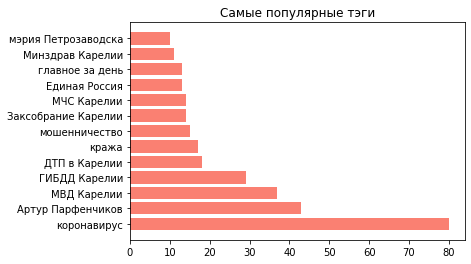

In [13]:
height = [c[1] for c in my_graf]
bars = tuple(c[0] for c in my_graf)
y_pos = np.arange(len(bars))
plt.barh(y_pos, height, color = 'salmon')
plt.yticks(y_pos, bars)
plt.title('Самые популярные тэги')
# Show graphic
plt.show()

In [5]:
two_query = """
SELECT article, head, subhead
FROM my_texts
    JOIN info ON my_texts.my_id = info.my_id"""


cur.execute(two_query)
t = cur.fetchall()

In [6]:
text = ''
for tt in t:
    text += tt[0] + ' ' + tt[1][:-17] + ' '
    if tt[2] != None:
        text += tt[2]

text = text.replace('\xa0', ' ').replace('\n', ' ')
#text

In [7]:
toks = word_tokenize(text)
lemmas = []
for tok in toks:
    p = morph.parse(tok)[0]
    if p.normal_form.isalpha():
        lemmas.append(p.normal_form)

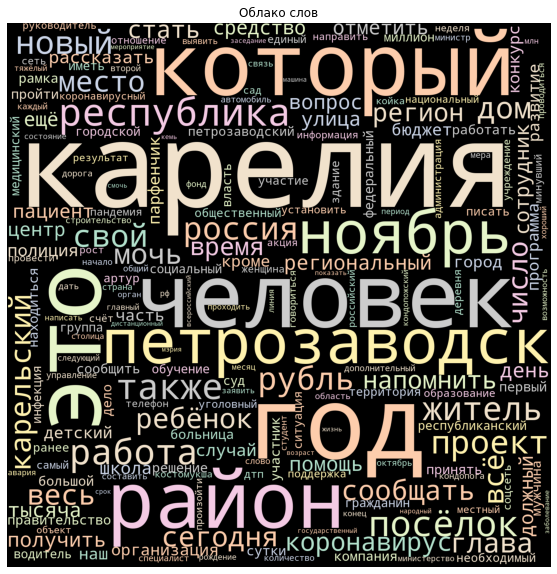

In [8]:
stops = set(stopwords.words('russian'))
new_text = ' '.join([word for word in lemmas if word not in stops])
wordcloud = WordCloud(
    background_color ='black',
    colormap = 'Pastel2',
    width = 1500,
    height = 1500, 
collocations = False).generate(new_text)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off") 
plt.title('Облако слов')
plt.show()

In [18]:
three_query = """
SELECT category
FROM my_texts
"""


cur.execute(three_query)
a = cur.fetchall()

In [19]:
cat_list = [aa[0] for aa in a]

In [20]:
my_graf = c.Counter(cat_list).most_common(6)

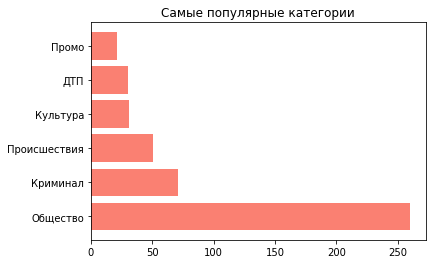

In [21]:
height = [c[1] for c in my_graf]
bars = tuple(c[0] for c in my_graf)
y_pos = np.arange(len(bars))
plt.barh(y_pos, height, color = 'salmon')
plt.yticks(y_pos, bars)
plt.title('Самые популярные категории')
# Show graphic
plt.show()